In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from keras.layers import Dense, Dropout, Activation, LSTM, Convolution1D, MaxPooling1D, Flatten
from keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
## Data preparation
%ls

 Archive.zip             'SP500 05-16.csv'
'CBOE yearly 04-18.csv'   stock_conv1d-Copy1.ipynb
'^DJI.csv'                stock_conv1d.ipynb
'EUR_GBP 05-16.csv'       stock_conv1d-out-of-sample.ipynb
'EUR_JPY 05-16.csv'       stock_dilatedconv+lstm.ipynb
'EUR_USD 05-16.csv'       stock_lstm+conv1d.ipynb
'GBP_JPY 05-16.csv'       stock_nn.ipynb
'GBP_USD 05-16.csv'       stock_rnn_lstm.ipynb
'^GSPC.csv'              'Volatility 05-16.csv'
 README.md


In [3]:
data= pd.read_csv('^DJI.csv')
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4279,2017-01-05,19924.560547,19948.599609,19811.119141,19899.289063,19899.289063,269920000
4280,2017-01-06,19906.960938,19999.630859,19834.080078,19963.800781,19963.800781,277700000
4281,2017-01-09,19931.410156,19943.779297,19887.380859,19887.380859,19887.380859,287060000
4282,2017-01-10,19876.349609,19957.119141,19836.029297,19855.529297,19855.529297,299410000
4283,2017-01-11,19887.380859,19973.419922,19833.160156,19954.279297,19954.279297,336150000


In [4]:
data= data.dropna(axis=0)#drop rows which may contain missing values
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4279,2017-01-05,19924.560547,19948.599609,19811.119141,19899.289063,19899.289063,269920000
4280,2017-01-06,19906.960938,19999.630859,19834.080078,19963.800781,19963.800781,277700000
4281,2017-01-09,19931.410156,19943.779297,19887.380859,19887.380859,19887.380859,287060000
4282,2017-01-10,19876.349609,19957.119141,19836.029297,19855.529297,19855.529297,299410000
4283,2017-01-11,19887.380859,19973.419922,19833.160156,19954.279297,19954.279297,336150000


In [5]:
data= data.values[:, 1:5]
print (data.shape)

(4284, 4)


In [6]:
print (data[:6, :])

[[11501.849609 11522.009766 11305.69043 11357.509766]
 [11349.75 11350.05957 10986.450195 10997.929688]
 [10989.370117 11215.099609 10938.669922 11122.650391]
 [11113.370117 11313.450195 11098.450195 11253.259766]
 [11247.05957 11528.139648 11239.919922 11522.55957]
 [11532.480469 11638.280273 11532.480469 11572.200195]]


In [7]:
y= data[1:, 3] #the close price
print (y.shape)
X= data[:4283,:]
print (X.shape)

(4283,)
(4283, 4)


In [8]:
y= (y- min(y))/(max(y)- min(y)) #??? normalsation
print (y[4270:])
print (y[:7])

[0.9958489671060151 0.9969608353545725 0.9977970638423223
 0.9895037255460575 0.9884685127944293 0.9842101331451283
 0.9930844240922265 0.9975826611512648 0.9943898946924046
 0.9991943173236132 0.9935030473634489 0.9911309455181354
 0.9984852177269742]
[0.3314732377562158 0.34076164281889654 0.3504885987356185
 0.3705443360966607 0.37424125426240135 0.36968941651198045
 0.3726698167615406]


In [9]:
X= (X- np.min(X,axis=0))/(np.max(X, axis=0)-np.min(X,axis=0))
print (X.shape)
print (X[:3, :])

(4283, 4)
[[0.36915916133693344 0.36210626788689226 0.3589471777635444
  0.35825247597887355]
 [0.35782701622684665 0.34916797410603573 0.335250623396864
  0.3314732377562158]
 [0.33097699895354726 0.3390129893215408 0.33170399075890933
  0.34076164281889654]]


In [10]:
## Sequence data preparation
"""
Rowling the window size = 100 days
This example is in sample forcasting
what is different of in sample and out of sample forecasting: 

https://stats.stackexchange.com/questions/260899/what-is-difference-between-in-sample-and-out-of-sample-forecasts
"""

'\nRowling the window size = 100 days\nThis example is in sample forcasting\nwhat is different of in sample and out of sample forecasting: \n\nhttps://stats.stackexchange.com/questions/260899/what-is-difference-between-in-sample-and-out-of-sample-forecasts\n'

In [11]:
time_steps= 100 #1 to 100 days ahead
X_new= np.zeros((X.shape[0] - time_steps +1, 100, X.shape[1]))
y_new= np.zeros((y.shape[0] -time_steps +1,))
for ix in range(X_new.shape[0]):
    for jx in range(time_steps):
        X_new[ix, jx, :]= X[ix +jx, :]
    y_new[ix]= y[ix + time_steps -1]
print (X_new.shape, y_new.shape)

(4184, 100, 4) (4184,)


In [12]:
## split into train and test sets

In [13]:
split = int(0.8*data.shape[0])
X_train = X_new[:split]
X_test = X_new[split:]

y_train = y_new[:split]
y_test = y_new[split:]

print (X_train.shape, y_train.shape)
print (X_test.shape, y_test.shape)

(3427, 100, 4) (3427,)
(757, 100, 4) (757,)


In [14]:
## Model fitting

In [15]:
model = Sequential()
model.add(Convolution1D(64, 3, input_shape= (100,4), border_mode='same'))
model.add(MaxPooling1D(pool_length=2))
model.add(Convolution1D(32, 3, border_mode='same'))
model.add(MaxPooling1D(pool_length=2))
model.add(Flatten())
model.add(Dense(output_dim=1))
model.add(Activation('linear'))

model.summary()

# from torchsummary import summary

# class model(nn.Module):
#     def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
#         super().__init__()
        
#         self.conv1 = nn.Conv1d(64, 3, (100,4), padding=0)
#         self.conv2 = nn.Conv1d(32,3,padding=0)
#         self.fc1 = nn.Linear(16, 1)
        
        
#     def forward(self,x):
#         out = self.conv1(x)
# #         out = F.relu(out)
#         out = F.max_pool1d(out, 2)
#         out = self.conv2(x)
# #         out = F.relu(out)
#         out = F.max_pool1d(out, 2)
#         out = out.view(out.shape[0], -1)
#         out = self.fc1(out)
#         out = F.relu(out)
#         return out
# summary(model)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 100, 64)           832       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 50, 32)            6176      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 25, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 800)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 801       
_________________________________________________________________
acti

/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, 3, input_shape=(100, 4), padding="same")`
  
/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  This is separate from the ipykernel package so we can avoid doing imports until
/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(32, 3, padding="same")`
  after removing the cwd from sys.path.
/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `MaxPooling1D` call to the Keras 2 API: `MaxPooling1D(pool_size=2)`
  """
/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
  import sys


In [16]:
model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])

In [17]:
model.fit(X_train, y_train, batch_size=256, nb_epoch=50,  verbose=2)

Instructions for updating:
Use tf.cast instead.


/home/wang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/50
 - 2s - loss: 0.0359 - acc: 2.9180e-04
Epoch 2/50
 - 0s - loss: 0.0051 - acc: 2.9180e-04
Epoch 3/50
 - 0s - loss: 0.0022 - acc: 2.9180e-04
Epoch 4/50
 - 0s - loss: 0.0014 - acc: 2.9180e-04
Epoch 5/50
 - 0s - loss: 9.9905e-04 - acc: 2.9180e-04
Epoch 6/50
 - 0s - loss: 8.4556e-04 - acc: 2.9180e-04
Epoch 7/50
 - 0s - loss: 7.6434e-04 - acc: 2.9180e-04
Epoch 8/50
 - 0s - loss: 7.2760e-04 - acc: 2.9180e-04
Epoch 9/50
 - 0s - loss: 6.8203e-04 - acc: 2.9180e-04
Epoch 10/50
 - 0s - loss: 6.5649e-04 - acc: 2.9180e-04
Epoch 11/50
 - 0s - loss: 6.3157e-04 - acc: 2.9180e-04
Epoch 12/50
 - 0s - loss: 6.0554e-04 - acc: 2.9180e-04
Epoch 13/50
 - 0s - loss: 5.8624e-04 - acc: 2.9180e-04
Epoch 14/50
 - 0s - loss: 5.6528e-04 - acc: 2.9180e-04
Epoch 15/50
 - 0s - loss: 5.4389e-04 - acc: 2.9180e-04
Epoch 16/50
 - 0s - loss: 5.2887e-04 - acc: 2.9180e-04
Epoch 17/50
 - 0s - loss: 5.1758e-04 - acc: 2.9180e-04
Epoch 18/50
 - 0s - loss: 4.9596e-04 - acc: 2.9180e-04
Epoch 19/50
 - 0s - loss: 4.8196e-0

In [18]:
score= model.evaluate(X_test, y_test, batch_size=256)

757/757 [==============================] - 0s 80us/step


In [19]:
print (score)

[0.00040132612446101585, 0.0013210039058038313]


In [20]:
y_pred= model.predict(X_test)
y_pred.shape

(757, 1)

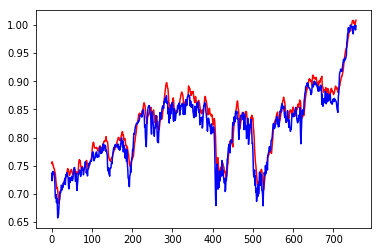

In [21]:
plt.plot(range(len(y_pred)), y_pred, 'r-')
plt.plot(range(len(y_test)), y_test, 'b-')
plt.show()

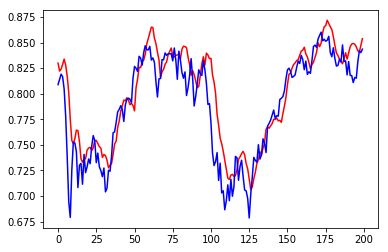

In [22]:
plt.plot(y_pred[400:600], 'r-')
plt.plot(y_test[400:600], 'b-')
plt.show()

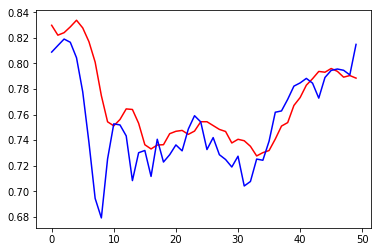

In [23]:
plt.plot(y_pred[400:450], 'r-')
plt.plot(y_test[400:450], 'b-')
plt.show()

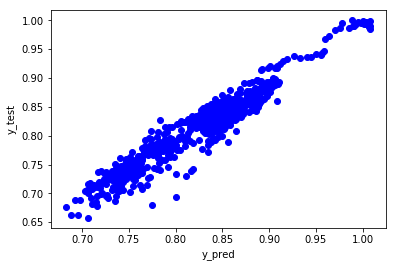

In [24]:
plt.plot (y_pred, y_test, 'bo')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()